Churn
False    2278
True      388
Name: count, dtype: int64
--- Churn Distribution (%) ---
Churn
False    85.446362
True     14.553638
Name: proportion, dtype: float64

Churn rate 0.145536384096024
--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-nul

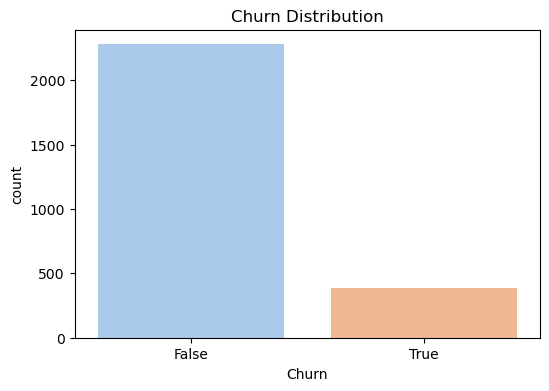

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 데이터 불러오기
df = pd.read_csv('C:/Users/ansun/Desktop/데이터분석/통계/archive/churn-bigml-80.csv')

# 타겟 분포
df.shape
df["Churn"].value_counts(normalize=True)

# Churn 분포(개수)
print(df['Churn'].value_counts())

#Churn 분포(비율)
print("--- Churn Distribution (%) ---")
print(df['Churn'].value_counts(normalize=True)*100)

# 이탈률만 별도
churn_rate = df['Churn'].mean()
print("\nChurn rate", churn_rate)

# 데이터 기본 정보 및 결측치 확인
print("--- Data Info ---")
print(df.info())

plt.figure(figsize=(6,4))
sns.countplot(
    x="Churn",
    hue="Churn",
    data=df,
    palette="pastel",
    legend=False)

plt.title("Churn Distribution")
plt.show()


# 분석 목표

고객 이탈의 경우 아래의 사유로 인해 설명될 수 있다.

**(1) 고객 불만(Customer service calls)**

**(2) 요금/사용량 부담(minutes/charge)**

**(3) 특정 서비스 플랜 가입 여부(International, Voice mail)**



In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
pd.set_option('display.max_columns', 50)

# 데이터 불러오기
df = pd.read_csv('C:/Users/ansun/Desktop/데이터분석/통계/archive/churn-bigml-80.csv')

y = df["Churn"].astype(int)

use_cols = ["Customer service calls",
    "International plan",
    "Voice mail plan",
    "Total day minutes",
    "Total eve minutes",
    "Total night minutes",
    "Total intl minutes"]

X = df[use_cols].copy()

# Yes/No 를 1/0 으로

X["International plan"] = X["International plan"].astype(str).str.strip().str.title().map({"Yes" : 1, "No" : 0})
X["Voice mail plan"] = X["Voice mail plan"].astype(str).str.strip().str.title().map({"Yes" : 1, "No" : 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

binary_cols = ["International plan", "Voice mail plan"]
num_cols = [c for c in X.columns if c not in binary_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("bin", "passthrough", binary_cols)
    ], remainder="drop"
)

pipe_logit = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear"))
])

pipe_rf = Pipeline([
    ("prep", ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), num_cols)
    ])),
    ("model", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_logit = {"model__C" : [0.1, 1, 10]}

grid_logit = GridSearchCV(
    pipe_logit,
    param_grid=param_grid_logit,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1
)
grid_logit.fit(X_train, y_train)

param_grid_rf = {
    "model__max_depth" : [None, 5, 10],
    "model__min_samples_leaf": [1,3,5]}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("== CV Results (PR-AUC) ===")
print("Best Logistic PR-AUC:", round(grid_logit.best_score_, 4),
      "Best Params:", grid_logit.best_params_)
print("Best RF PR-AUC    :", round(grid_rf.best_score_, 4),
      "Best params", grid_rf.best_params_)



== CV Results (PR-AUC) ===
Best Logistic PR-AUC: 0.4806 Best Params: {'model__C': 10}
Best RF PR-AUC    : 0.6546 Best params {'model__max_depth': 5, 'model__min_samples_leaf': 5}


# 결과

## 무엇을 측정한 값인가?

평가지표: PR-AUC (Average Precision)

교차검증: Stratified 5-Fold

PR-AUC → **이탈 고객(양성 클래스)** 을 얼마나 잘 찾아내는지를 평가

**불균형 데이터(Churn)** 에서 Accuracy나 ROC-AUC보다 더 적절

즉, 이 수치는 **“이탈 고객을 얼마나 안정적으로 잘 맞추는가”** 를 의미함

## Logistic Regression 결과

Best Logistic PR-AUC: 0.4806

Best Params: C = 10

* PR-AUC ≈ 0.48
* 무작위 분류(PR-AUC ≈ 이탈 비율 ≈ 0.14~0.15)보다는 훨씬 낫지만 예측력이 아주 뛰어나다고 보긴 어렵다.

C=10의 의미는 규제가 약한 모델

즉, 변수들의 영향이 비교적 선형적으로 분리 가능 하지만 churn은 단순 선형 관계만으로는 설명이 부족하며, 선형 모델의 한계를 보여준다.

## Random Forest 결과

Best RF PR-AUC: 0.6546

Best Params:
- max_depth = 5
- min_samples_leaf = 5

* PR-AUC ≈ 0.65
* Logistic 대비 약 0.17p 향상
* 이탈 고객을 훨씬 더 정확히 찾아냄

**하이퍼파라미터 의미**

* max_depth=5: 너무 복잡하지 않은 중간 깊이
* min_samples_leaf=5: 노이즈 방지 → 일반화 성능 ↑

즉, 과적합 없이 비선형 패턴을 잘 포착된다.


## 결론

### 분석 목표와 연결

고객 이탈은

(1) 고객 불만,

(2) 요금/사용량 부담,

(3) 특정 서비스 플랜

에 의해 설명될 수 있다.


**교차검증 결과, Random Forest 모델은 PR-AUC 기준으로 Logistic Regression 대비 유의미하게 높은 성능을 보였으며, 이는 고객 이탈이 단순 선형 관계가 아닌 복합적·비선형적 요인에 의해 발생함을 시사한다.**


# Test set

In [11]:
df_test = pd.read_csv('C:/Users/ansun/Desktop/데이터분석/통계/archive/churn-bigml-20.csv')

y_test = df_test["Churn"].astype(int)

X_test = df_test[use_cols].copy()
X_test["International plan"] = X_test["International plan"].astype(str).str.strip().str.title().map({"Yes":1,"No":0})
X_test["Voice mail plan"] = X_test["Voice mail plan"].astype(str).str.strip().str.title().map({"Yes":1,"No":0})

best_rf = grid_rf.best_estimator_

y_proba = best_rf.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

print("Test PR-AUC:", average_precision_score(y_test, y_proba))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Test PR-AUC: 0.6733279542169616
Test ROC-AUC: 0.870887007729113
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       572
           1       0.55      0.77      0.64        95

    accuracy                           0.88       667
   macro avg       0.75      0.83      0.78       667
weighted avg       0.90      0.88      0.89       667

[[512  60]
 [ 22  73]]


## Test set 성능 수치 해석 및 결과

### 📊 PR-AUC

```
Test PR-AUC = 0.673
```

* 무작위 분류 기준(PR-AUC ≈ 0.14) 대비 **매우 우수**
* CV 결과(0.6546)보다 오히려 소폭 상승 → **과적합 없이 일반화 성능 유지**

**이 모델은 이탈 고객을 안정적으로 식별할 수 있는 예측력을 가진다.**

---

### 📈 ROC-AUC

```
Test ROC-AUC = 0.871
```

* 클래스 구분 능력이 매우 뛰어남
* 이탈/비이탈 고객 간 **명확한 분리 가능**

단, churn 문제에서는 **PR-AUC가 더 중요** → ROC-AUC는 “보조 지표”로 해석

---

## Classification Report 핵심 해석

### 이탈 고객(1번 클래스)

```
precision = 0.55
recall    = 0.77
f1-score  = 0.64
```

* Recall 0.77 → **이탈 고객의 77%를 성공적으로 탐지**
* Precision 0.55 → 이탈로 예측한 고객 중 절반 이상이 실제 이탈

churn 문제에서 **Recall 중심 전략** 이므로 → **비즈니스적으로 매우 합리적인 결과**

---

### 비이탈 고객(0번 클래스)

```
precision = 0.96
recall    = 0.90
```

* 비이탈 고객도 안정적으로 분류
* 모델이 “아무나 이탈로 찍는 모델”은 아님

---

## Confusion Matrix 해석

```
[[512  60]
[ 22  73]]
```

| 실제\예측 | 비이탈      | 이탈      |
| ----- | -------- | ------- |
| 비이탈   | 512 (TN) | 60 (FP) |
| 이탈    | 22 (FN)  | 73 (TP) |

---

### TP (73명)

실제 이탈 고객 중 73명을 정확히 예측하여, 이탈 위험 고객을 효과적으로 식별함을 확인할 수 있다.

---

### FN (22명)

22명의 이탈 고객을 놓쳤으며, 이는 임계값 조정이나 추가 변수 도입을 통해 개선이 가능한 부분이다.

churn 문제에서 **가장 중요한 오류** → 그래도 FN 비율은 비교적 낮음 (22 / 95 ≈ 23%)

---

### FP (60명)

실제로는 이탈하지 않았으나 이탈로 예측된 고객이 존재하며, 이는 마케팅 비용 증가 가능성을 의미한다.

→  **Recall을 높이기 위한 감수 가능한 비용**

---

### TN (512명)

다수의 비이탈 고객을 정확히 분류하여 모델의 전반적인 안정성을 보여준다.

---

## Test 결과 → 가설 검증 연결

분리된 test set에서 Random Forest 모델은 PR-AUC 0.67의 성능을 보였으며, 이는 고객 이탈을 안정적으로 예측할 수 있는 수준이다.

특히 높은 Recall을 통해 고객 불만, 통화 사용량에 따른 요금 부담, 서비스 플랜 가입 여부가 이탈 여부를 설명하는 데 유의미한 정보를 제공함을 확인하였다.

따라서 본 분석에서 설정한 가설은 **test 데이터에서도 전반적으로 뒷받침됨** 을 알 수 있다.

---
## 요약
* PR-AUC 0.67 → 이탈 예측력 충분
* Recall 0.77 → 이탈 고객 대부분 탐지
* FN < FP → churn 문제에 적합한 전략
* test에서도 성능 유지 → 과적합 아님
### **가설 전반적 뒷받침됨**

---


